In [121]:
#### import modules
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from pprint import pprint
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from sklearn.preprocessing import QuantileTransformer

In [122]:
#### training data set
X_train = train_activity= pd.read_csv('../transformed/real_values_int.csv')

#### load activity dataset
train_label = pd.read_csv('../lite_data/train_label_lite.csv')

In [123]:
def new_variable_checker(total, var):
    
    col_name = var.name
#     #### 표준화
#     var = (var - var.mean())/var.std()
    
    df = total.loc[:,('label',col_name)]
    #### rank transformation
    q_t = QuantileTransformer()
    df[col_name] = pd.Series(q_t.fit_transform(df[col_name].values.reshape(-1, 1)).reshape(-1),name = col_name)
    
    #### 검정을 위한 표 만들기

    table = df.pivot(columns='label',values = col_name)
    table = pd.concat((table['retained'].dropna().reset_index(drop = True),
               table['2month'].dropna().reset_index(drop = True),
               table['month'].dropna().reset_index(drop = True),
               table['week'].dropna().reset_index(drop = True)),axis = 1)
    
    #### 정규성 검정
    _, n_0 = kstest(table['retained'],'norm')
    _, n_1 = kstest(table['2month'],'norm')
    _, n_2 = kstest(table['month'],'norm')
    _, n_3 = kstest(table['week'],'norm')
    
    #### box plot
    table.plot.box()
    
    ##### 네 집단 사이의 평균검정.
    
    if (n_0 <0.05) and (n_1 <0.05) and (n_2 <0.05) and (n_3 <0.05): 
        pprint("변수 %s는 정규성을 가정할 수 없습니다."%col_name)
        print(n_0,n_1,n_2,n_3)
        print()
        s, p = kruskal(table['retained'],table['2month'],table['month'],table['week'])
    
        if p >= 0.1: # 차이 없음
            pprint('통계적으로 네 집단의 차이가 유의하지 않음.')
            return
        else:
            pprint('통계적으로 네 집단의 차이가 유의함.')
            
        #### Mahn-whiteney검정
        mw_result = []
        for c1, c2 in combinations(table.columns,2):
            u, p = mannwhitneyu(table[c1],table[c2],alternative='two-sided')
            mw_result.append((c1,c2,p))
            
        result = pd.DataFrame(mw_result,columns=['Group1','Group2','reject'])
        result['reject'] = result.reject.apply(lambda x: True if x < (0.1/6) else False) #본페르니
        pprint(result)

    else: # Normal Distribution
        pprint("변수 %s의 모집단은 정규분포를 따릅니다."%col_name)
        print()
        model = ols(col_name + ' ~ label', df).fit()
        result = anova_lm(model)
        pprint(result)
        p = result.iloc[0,-1]
        
        if p >= 0.1: # 차이 없음
            pprint('통계적으로 네 집단의 차이가 유의하지 않음.')
            return
        else:
            pprint('통계적으로 네 집단의 차이가 유의함.')
        
        #### tukey hsd 검정.(사후검정)
        result = pairwise_tukeyhsd(df.iloc[:,1], df.iloc[:,0],alpha=0.1)
        print(result.summary())
        print()
        result.plot_simultaneous()
    
    return result.reject

---

eda_fe

---

In [234]:
duel_temp = train_activity.loc[:,['new_id','duel_cnt','duel_win']]

In [235]:
duel_temp['duel'] = duel_temp['duel_cnt'] - duel_temp['duel_win']

In [238]:
duel_temp.max()

new_id      tr99999
duel_cnt       9578
duel_win       4491
duel           5203
dtype: object

In [239]:
new_fe = temp.loc[:,['new_id','duel']].groupby(by='new_id').median()
eda_duel = pd.merge(train_label,new_fe,left_on='new_id',right_on=new_fe.index)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [233]:
eda_duel.duel.value_counts()

0.0    51343
Name: duel, dtype: int64

In [232]:
eda_duel.loc[eda_duel.duel > ,:]

,new_id,label,duel


In [226]:
eda_duel

,new_id,label,duel
0,tr2,retained,0.0
1,tr3,week,0.0
2,tr4,retained,0.0
3,tr6,month,0.0
4,tr11,retained,0.0
5,tr16,week,0.0
6,tr19,retained,0.0
7,tr21,month,0.0
8,tr22,week,0.0
9,tr23,retained,0.0


In [209]:
temp = train_activity.loc[~((train_activity.cnt_enter_inzone_normal ==0)&(train_activity.cnt_clear_inzone_normal ==0)),['new_id','cnt_enter_inzone_normal','cnt_clear_inzone_normal']]

In [210]:
temp['inzone_normal'] = temp['cnt_enter_inzone_normal'] - temp['cnt_clear_inzone_normal']

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 inzone_normal의 모집단은 정규분포를 따릅니다.'

               df       sum_sq     mean_sq            F  PR(>F)
label         3.0   516.781388  172.260463  2388.828166     0.0
Residual  51339.0  3702.099638    0.072111          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.1632  -0.1743  -0.152  True 
 2month  retained  0.1063   0.0958  0.1169  True 
 2month    week   -0.0642  -0.0745 -0.0538  True 
 month   retained  0.2695   0.2618  0.2772  True 
 month     week    0.099    0.0916  0.1064  True 
retained   week   -0.1705   -0.177  -0.164  True 
-------------------------------------------------



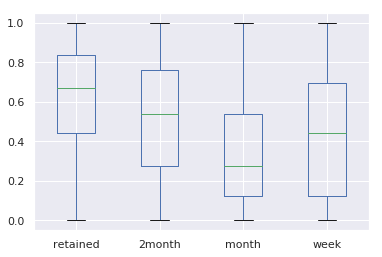

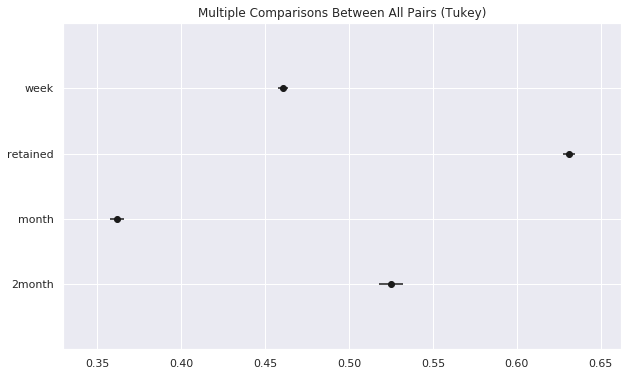

In [216]:
new_fe = temp.loc[:,['new_id','inzone_normal']].groupby(by='new_id').sum()
eda = pd.merge(train_label,new_fe,left_on='new_id',right_on=new_fe.index)
new_variable_checker(eda,eda.inzone_normal);

---

In [148]:
non_zero_full = pd.merge(train_label,train_activity.loc[train_activity.gathering_cnt !=0,['new_id','cnt_enter_bam']])

In [149]:
table = non_zero_full.pivot(columns='label',values = 'cnt_enter_bam')
table = pd.concat((table['retained'].dropna().reset_index(drop = True),
           table['2month'].dropna().reset_index(drop = True),
           table['month'].dropna().reset_index(drop = True),
           table['week'].dropna().reset_index(drop = True)),axis = 1)

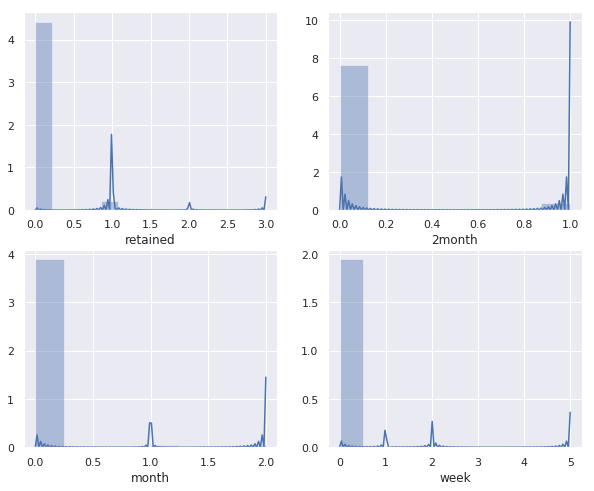

In [150]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
sns.distplot(table['retained'].dropna());

plt.subplot(222)
sns.distplot(table['2month'].dropna());

plt.subplot(223)
sns.distplot(table['month'].dropna());

plt.subplot(224)
sns.distplot(table['week'].dropna());

In [39]:
table['2month'].dropna().value_counts()

8610.0        8812
2588780.0      254
17220.0        158
4271320.0       67
87150.0         53
4298120.0       48
2590480.0       47
11131420.0      42
8542640.0       39
5953860.0       35
2575120.0       29
5800.0          28
10225180.0      25
6860100.0       24
4200.0          22
206750.0        22
2576820.0       22
427530.0        22
15402740.0      22
2800.0          21
1682540.0       21
1709340.0       19
5980560.0       19
4298020.0       18
2501630.0       16
460300.0        15
12610.0         15
619670.0        14
1468500.0       14
1693360.0       13
              ... 
665580.0         1
626040.0         1
2138000.0        1
567260.0         1
2531580.0        1
86550.0          1
1069420.0        1
9340090.0        1
405570.0         1
390230.0         1
1626440.0        1
22760.0          1
9865740.0        1
382030.0         1
30698.0          1
59940.0          1
623280.0         1
18720.0          1
118670.0         1
13273060.0       1
813180.0         1
4104666.0   

quest_exp에 있는 특정 값의 비밀

In [62]:
train_activity.loc[train_activity.quest_hongmun !=0,['new_id','quest_hongmun']].quest_hongmun.value_counts().sort_index()

70            1
130           3
200           4
300           3
340           5
360           6
400           1
430           8
450           1
480           1
490           3
500          46
550           3
570           9
600           2
650          20
651           1
670           1
680           2
690           1
700           2
715           3
720           3
741           2
750           4
780          49
830           1
845           2
860           2
870           1
             ..
71928601      1
72679601      1
73381801      1
73643671      1
73778951      1
75886501      1
76293631      1
76996551      1
76997751      1
77393551      1
79479651      1
79609501      1
83391151      1
83455551      1
86515001      1
86826551      1
87535701      1
88902901      1
89827351      1
92245101      1
93997201      1
94580351      1
101323051     1
105227101     1
105810971     1
107617051     1
110143101     1
151691390     1
157509002     1
227177753     1
Name: quest_hongmun, Len

In [60]:
train_activity.loc[train_activity.quest_hongmun !=0,['new_id','quest_hongmun']].quest_hongmun.value_counts()[4500000]/len(train_activity.loc[train_activity.quest_hongmun !=0,['new_id','quest_hongmun']].quest_hongmun)

0.0449871172218802

In [66]:
train_activity.loc[train_activity.npc_exp !=0,['new_id','npc_exp']].npc_exp.value_counts()[28]/len(train_activity.loc[train_activity.npc_exp !=0,['new_id','npc_exp']].npc_exp)

0.22784978398138916

In [67]:
train_activity.loc[train_activity.quest_exp !=0,['new_id','quest_exp']].quest_exp.value_counts()[8610]/len(train_activity.loc[train_activity.quest_exp !=0,['new_id','quest_exp']].quest_exp)

0.2189144966323774

In [119]:
ta = pd.read_csv('../lite_data/train_activity_lite.csv')

In [120]:
ta.head()

,new_id,wk,cnt_dt,play_time,npc_exp,npc_hongmun,quest_exp,quest_hongmun,item_hongmun,game_combat_time,...,cnt_clear_bam,normal_chat,whisper_chat,district_chat,party_chat,guild_chat,faction_chat,cnt_use_buffitem,gathering_cnt,making_cnt
0,tr0,8,1,-0.661470,-0.231874,-0.290803,-0.250423,-0.487666,-0.306354,-0.569842,...,-0.03313,-0.034038,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,-0.503692,-0.027758,-0.365536
1,tr1,8,1,-0.266961,1.185225,-0.290803,0.251172,-0.487666,-0.306354,-0.309368,...,-0.03313,-0.016354,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,0.065089,-0.027758,-0.365536
2,tr2,5,3,1.025391,3.569807,-0.241648,2.333390,1.298843,-0.306354,0.818823,...,-0.03313,0.054378,-0.231827,-0.016574,-0.167158,-0.343293,-0.024028,1.115979,-0.027758,-0.365536
3,tr2,6,7,3.957989,9.314319,-0.046188,8.192729,6.658372,-0.306354,3.619399,...,-0.03313,0.266577,-0.231827,-0.016574,-0.015936,-0.343293,-0.024028,4.458242,-0.027758,-0.365536
4,tr2,8,2,0.032587,-0.231874,-0.006354,-0.250423,-0.336445,-0.069520,0.401743,...,-0.03313,-0.034038,-0.108600,-0.016574,-0.080745,-0.343293,-0.024028,0.363021,-0.027758,-0.365536
